In [1]:

from PIL import Image
from matplotlib import pyplot as plt
from functools import partial
from multiprocessing import shared_memory

import multiprocessing
import numpy as np, os


In [15]:
path = './p6'
bin_width = int(2)
N_average = int(100)

reader = Image.open(f'{path}/{1:05}.JPG')
width, height = reader.size

N_bins = int(width/bin_width)
N_frames = N_bins + N_average - 1

bin_list = range(1, N_bins+1)

print(width, N_bins, N_frames, bin_list)

6192 3096 3195 range(1, 3097)


# find which images are used in each bin

In [35]:
left_to_right = False  ## arrow of time in final image

bin_has_imgs = {i:list(range(i, i+N_average)) for i in bin_list}

if left_to_right:
    
    bin_edges = {i:[(i-1)*bin_width, i*bin_width] for i in bin_list}

else:
    
    bin_edges = {i:[width-i*bin_width, width-(i-1)*bin_width] for i in bin_list}

img_used_in_bin = {}

for frame_ind in range(1, N_frames+1):

    img_used_in_bin[frame_ind] = list(range(max(1,frame_ind-N_average+1), min(frame_ind+1, N_bins+1)))


# Option 1 (slow) Read images, crop into bins and save bins to disk

In [4]:

img_stack = np.zeros((height, width, 3), dtype=int)
bin_stack = np.zeros((height, bin_width, 3, N_average), dtype=int)

print(img_stack.shape)
print(bin_stack.shape)


(4128, 6192, 3)
(4128, 2, 3, 100)


In [20]:

def read_imgs_for_this_bin(shared_mem_name, shape, dtype, frame_ind, stack_ind, left, right):
    
    existing_shm = shared_memory.SharedMemory(name=shared_mem_name)
    shared_array = np.ndarray(shape=shape, dtype=dtype, buffer=existing_shm.buf)

    reader = Image.open(f'{path}/{frame_ind:05}.JPG')        
    shared_array[:,:,:,stack_ind] = np.array(reader.crop((left, top, right, bottom)))

    existing_shm.close()


In [10]:

top = 0
bottom = height

for bin_ind in bin_list:
    
    if bin_ind % 500 == 0:
        print(bin_ind)

    left, right = bin_edges[bin_ind]
    imgs_for_this_bin = bin_has_imgs[bin_ind]

    
    shm = shared_memory.SharedMemory(create=True, size=bin_stack.nbytes)
    shared_array = np.ndarray(bin_stack.shape, dtype=bin_stack.dtype, buffer=shm.buf)
    shared_array[:] = bin_stack[:]

    processes = []
    for stack_ind, frame_ind in enumerate(imgs_for_this_bin):

        p = multiprocessing.Process(target=read_imgs_for_this_bin, args=(shm.name, bin_stack.shape, bin_stack.dtype, \
                                                                         frame_ind, stack_ind, left, right))
        processes.append(p)
        p.start()
    
    for p in processes:
        p.join()

    img_stack[:, left:right, :] = np.median(shared_array, axis=3)

    shm.close()
    shm.unlink()



# Option 2 (faster) read images, devide into bins and save each bin to disk. And read bins again for stacking

In [9]:
for frame_ind in range(1, N_frames+1):
    bashCommand = f'mkdir {path}/{frame_ind}'
    os.system(bashCommand)

In [10]:
use_multiprocessing = False

def save_bin(shared_mem_name, shape, dtype, frame_ind, bin_ind, L, R):
    
    existing_shm = shared_memory.SharedMemory(name=shared_mem_name)
    shared_array = np.ndarray(shape=shape, dtype=dtype, buffer=existing_shm.buf)

    img_in_bin = shared_array[:, L:R,:]
    np.save(f'{path}/{frame_ind}/{bin_ind}_new.npy', img_in_bin)

    existing_shm.close()


In [47]:

for frame_ind in range(1, N_frames+1):

    if frame_ind % 500 == 0:
        print(frame_ind)
        
    reader = Image.open(f'{path}/{frame_ind:05}.JPG')
    img_array = np.array(reader)

    bins_from_img = img_used_in_bin[frame_ind]   ## take these bins from this image and save to disk as np array

    if use_multiprocessing:

        shm = shared_memory.SharedMemory(create=True, size=img_array.nbytes)
        shared_array = np.ndarray(img_array.shape, dtype=img_array.dtype, buffer=shm.buf)
        shared_array[:] = img_array[:]
        
        processes = []
        for bin_ind in bins_from_img:
            L, R = bin_edges[bin_ind]
            p = multiprocessing.Process(target=save_bin, args=(shm.name, img_array.shape, img_array.dtype, frame_ind, bin_ind, L, R))
            processes.append(p)
            p.start()
    
        for p in processes:
            p.join()
            
        shm.close()
        shm.unlink()
                        
    else:
        for bin_ind in bins_from_img:
            L, R = bin_edges[bin_ind]
            img_in_bin = img_array[:, L:R, :]
            np.save(f'{path}/{frame_ind}/{bin_ind}.npy', img_in_bin)
    

In [48]:
img_stack = np.zeros((height, width, 3), dtype=int)
bin_stack = np.zeros((height, bin_width, 3, N_average), dtype=int)

print(img_stack.shape)
print(bin_stack.shape)


(4128, 6192, 3)
(4128, 2, 3, 100)


In [49]:

for bin_ind in bin_list:
    
    if bin_ind % 500 == 0:
        print(bin_ind)
    
    imgs_for_this_bin = bin_has_imgs[bin_ind]

    for stack_ind, frame_ind in enumerate(imgs_for_this_bin):
        bin_stack[:,:,:,stack_ind] = np.load(f'{path}/{frame_ind}/{bin_ind}.npy')

    L, R = bin_edges[bin_ind]
    img_stack[:, L:R, :] = np.median(bin_stack, axis=3)



500
1000
1500
2000
2500
3000


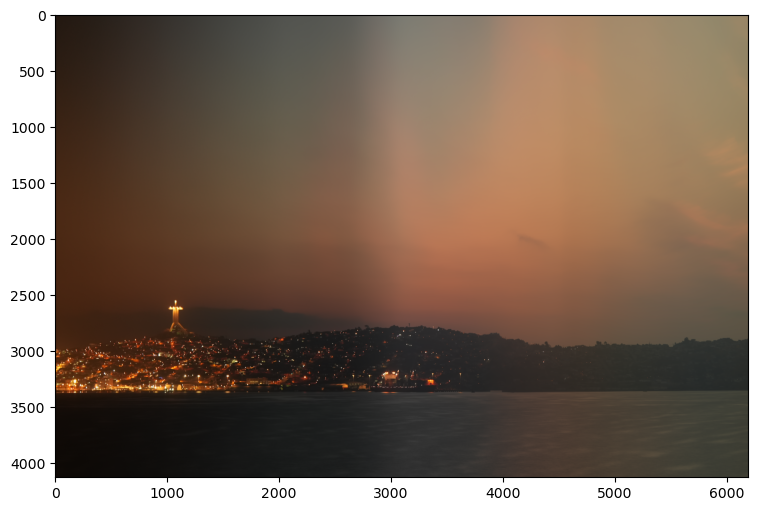

In [56]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.imshow(img_stack)

plt.show()

# compensate dark columns due to camera ISO/Exposure jumps

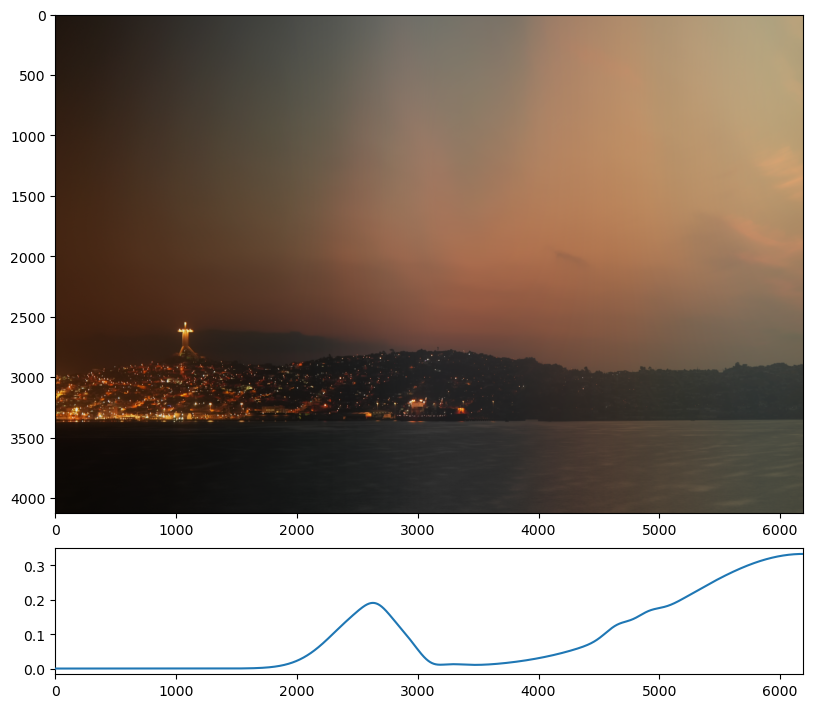

In [215]:
mu = width
sigma = 1000
gauss = np.exp(-(np.array(range(width)) - mu )**2/(2*sigma**2)) / 3

mu = 4650
sigma = 100
gauss += np.exp(-(np.array(range(width)) - mu )**2/(2*sigma**2)) / 40

mu = 4900
sigma = 100
gauss += np.exp(-(np.array(range(width)) - mu )**2/(2*sigma**2)) / 50

mu = 2600
sigma = 300
gauss += np.exp(-(np.array(range(width)) - mu )**2/(2*sigma**2)) / 6

mu = 2650
sigma = 100
gauss += np.exp(-(np.array(range(width)) - mu )**2/(2*sigma**2)) / 40


mu = 3100
sigma = 100
gauss -= np.exp(-(np.array(range(width)) - mu )**2/(2*sigma**2)) / 40

filt = np.ones(img_stack.shape)
for i in range(3):
    filt[:,:,i] += gauss



final_img = np.uint8((img_stack*filt/1.1).clip(0,255))

fig, axes = plt.subplot_mosaic([['image'],['filter']], figsize=(8, 7),
                               constrained_layout=True,
                               gridspec_kw={'height_ratios':(4,1)})

axes['filter'].sharex(axes['image'])
axes['image'].sharex(axes['filter'])

axes['image'].imshow(final_img)
axes['filter'].plot(gauss, zorder=100)

plt.show()

In [216]:
saver = Image.fromarray(np.uint8(final_img.clip(0,255)))
saver.save('p6.JPG', 'JPEG')
